In [1]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data
import math

In [2]:
def getCloseDataPandas(ticker, start,end=None):
    #print("ticker: " ,ticker)
    return data.get_data_yahoo(ticker, start,end)['Close']

def getCloseData(ticker, start, end=None):
    #print("ticker: " ,ticker)
    return fdr.DataReader(ticker,start,end)['Close']

def getDayReturn(closeDataSet):
    return (closeDataSet/closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    
    #plt.figure(figsize=(15,5))
    #plt.plot(-dd, label="DrawDown")
    #plt.legend(fontsize = 16)
    mdd = dd.max()
    
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 1, 1)
    cumulativeReturn.plot(color="green")
    plt.ylabel("profit", fontsize=20)

    plt.subplot(2, 1, 2)
    plt.plot(-dd, color="red")
    plt.ylabel("draw down", fontsize=20)

    plt.show()

    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd


def getRebalancingDate(closeDataSet, period):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 

    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period , weightDf=None):
    if weightDf is None : 
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    else:
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
        for i in range(0, len(weightDf.columns)):
            print(weightDf.columns[i] , "비율 : ")
            weightDf[weightDf.columns[i]] = float(input())
            

    portfolio = pd.DataFrame()
    totalAsset = 1 
    start = rebalancingDate[0] 
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end] 
        cumReturn = getCumulativeReturn(priceData) 
        weightedCumReturn = weight * cumReturn 
        netCumReturn = totalAsset * weightedCumReturn
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumReturn])
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] 
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 


In [4]:
SPY = getCloseDataPandas("SPY","1994-01","2022-09-30") 
TLT = getCloseDataPandas("TLT","1994-01","2022-09-30") 
GLD = getCloseDataPandas("GLD","1994-01","2022-09-30") 
BIL = getCloseDataPandas("BIL","1994-01","2022-09-30") 

In [5]:
SPY

Date
1993-12-31     46.593750
1994-01-03     46.468750
1994-01-04     46.656250
1994-01-05     46.750000
1994-01-06     46.750000
                 ...    
2022-09-26    364.309998
2022-09-27    363.380005
2022-09-28    370.529999
2022-09-29    362.790009
2022-09-30    357.179993
Name: Close, Length: 7240, dtype: float64

In [6]:
TLT

Date
2002-07-30     81.519997
2002-07-31     82.529999
2002-08-01     83.000000
2002-08-02     83.849998
2002-08-05     84.220001
                 ...    
2022-09-26    103.680000
2022-09-27    100.949997
2022-09-28    104.330002
2022-09-29    103.790001
2022-09-30    102.449997
Name: Close, Length: 5080, dtype: float64

In [7]:
GLD

Date
2004-11-18     44.380001
2004-11-19     44.779999
2004-11-22     44.950001
2004-11-23     44.750000
2004-11-24     45.049999
                 ...    
2022-09-26    151.229996
2022-09-27    151.539993
2022-09-28    154.690002
2022-09-29    154.660004
2022-09-30    154.669998
Name: Close, Length: 4498, dtype: float64

In [8]:
BIL

Date
2007-05-30    91.599998
2007-05-31    91.599998
2007-06-01    91.620003
2007-06-04    91.639999
2007-06-05    91.639999
                ...    
2022-09-26    91.540001
2022-09-27    91.570000
2022-09-28    91.580002
2022-09-29    91.599998
2022-09-30    91.599998
Name: Close, Length: 3864, dtype: float64

In [9]:
closeDataSet = pd.concat([SPY,TLT,GLD, BIL], axis=1)
closeDataSet.columns = ["SPY","TLT","GLD", "BIL"]
closeDataSet.dropna(inplace = True)

In [10]:
closeDataSet

,SPY,TLT,GLD,BIL
Date,,,,
2007-05-30,153.479996,86.540001,64.720001,91.599998
2007-05-31,153.320007,86.379997,65.540001,91.599998
2007-06-01,154.080002,85.589996,66.440002,91.620003
2007-06-04,154.100006,85.980003,66.540001,91.639999
2007-06-05,153.490005,85.440002,66.370003,91.639999
...,...,...,...,...
2022-09-26,364.309998,103.680000,151.229996,91.540001
2022-09-27,363.380005,100.949997,151.539993,91.570000
2022-09-28,370.529999,104.330002,154.690002,91.580002


In [11]:
rebalancingDate = getRebalancingDate(closeDataSet, "year")
rebalancingDate

DatetimeIndex(['2007-09-28', '2008-09-30', '2009-09-30', '2010-09-30',
               '2011-09-30', '2012-09-28', '2013-09-30', '2014-09-30',
               '2015-09-30', '2016-09-30', '2017-09-29', '2018-09-28',
               '2019-09-30', '2020-09-30', '2021-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [13]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet,"year")

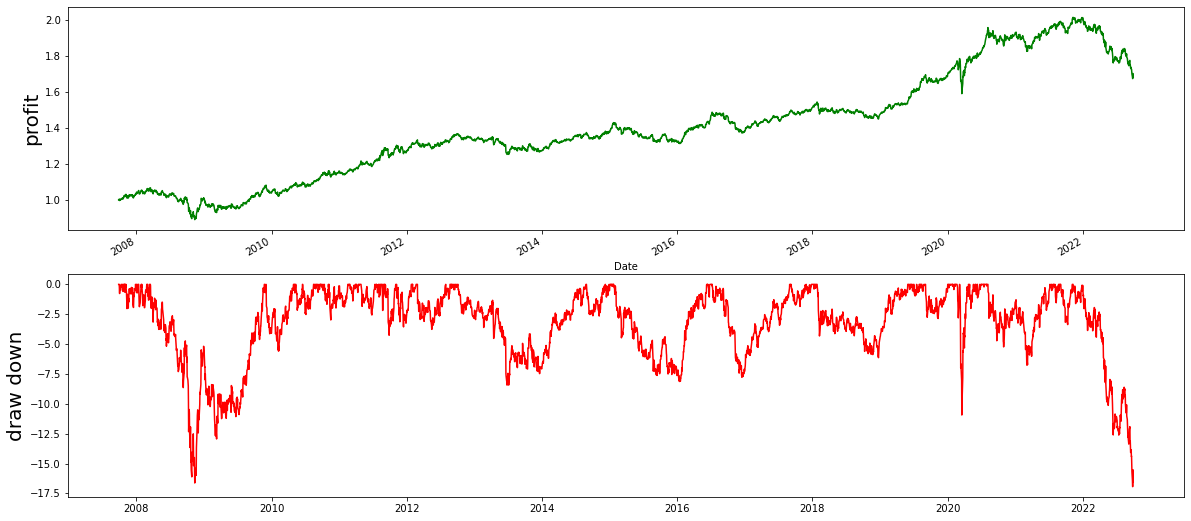

최종 수익률 : 1.6833350966471365
cagr: 1.0353377003376023
mdd: 16.937014939108042


In [14]:
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)